https://github.com/arkanivasarkar/Retinal-Vessel-Segmentation-using-variants-of-UNET

## Carregar model

In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
#import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
import glob, random, os, warnings
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage
import cv2
from patchify import patchify, unpatchify
from skimage.transform import resize
from skimage.io import imread
from skimage.io import imsave
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.morphology import skeletonize
from skimage.morphology import dilation, square
from skan import Skeleton, summarize


## Model de predicció del patró vascular

In [3]:
def IoU_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def IoU_loss(y_true, y_pred):
    return -IoU_coef(y_true, y_pred)

In [4]:
def clahe_equalized(imgs):    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))    
    imgs_equalized = clahe.apply(imgs)
    return imgs_equalized

In [5]:
import pickle
from keras.models import load_model

filename = 'retina_Unet_150epochs'
model = load_model(filename+'.hdf5', custom_objects={'IoU_loss': IoU_loss, 'IoU_coef': IoU_coef})
        

In [6]:
# function to resize image to the next multiple of patch_size
def resize_to_fit(image, target_size):
    height, width = image.shape[:2]
    new_height = ((height // target_size) + 1) * target_size
    new_width = ((width // target_size) + 1) * target_size
    resized_image = cv2.resize(image, (new_width, new_height))
    return resized_image


In [7]:
#funció per retornat el patró vascular 
def vessel_pattern(imgpath):
    reconstructed_image = []
    test_img = skimage.io.imread(imgpath) #test image
    test_img = resize_to_fit(test_img, 512)
    patch_size = 512

    predicted_patches = []  

    test = test_img[:,:,1] #selecting green channel
    test = clahe_equalized(test) #applying CLAHE
    SIZE_X = (test_img.shape[1]//patch_size)*patch_size #getting size multiple of patch size
    SIZE_Y = (test_img.shape[0]//patch_size)*patch_size #getting size multiple of patch size
    test = cv2.resize(test, (SIZE_X, SIZE_Y))        
    test = np.array(test)
    patches = patchify(test, (patch_size, patch_size), step=patch_size) #create patches(patch_sizexpatch_sizex1)

    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            single_patch = patches[i,j,:,:]
            single_patch_norm = (single_patch.astype('float32')) / 255.
            single_patch_norm = np.expand_dims(np.array(single_patch_norm), axis=-1)
            single_patch_input = np.expand_dims(single_patch_norm, 0)
            single_patch_prediction = (model.predict(single_patch_input)[0,:,:,0] > 0.5).astype(np.uint8) #predict on single patch
            predicted_patches.append(single_patch_prediction)
    predicted_patches = np.array(predicted_patches)
    predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], patch_size,patch_size) )
    reconstructed_image = unpatchify(predicted_patches_reshaped, test.shape) #join patches to form whole img
    return(reconstructed_image)


1/1 [==============================] - 0s 24ms/step


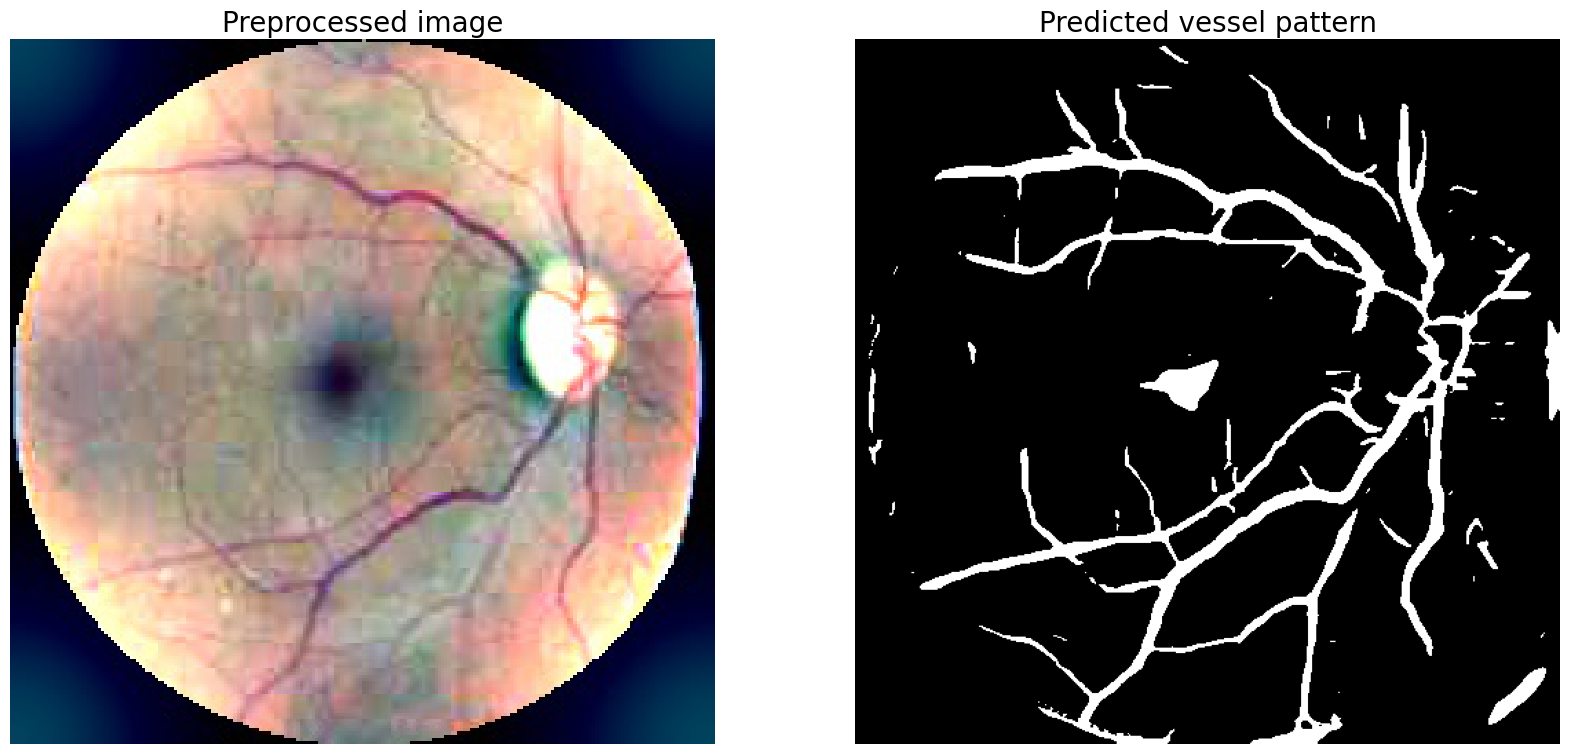

In [11]:
imgpath='test_preprocessed/DR/test_004.jpg'
image_preprocessed= skimage.io.imread(imgpath)
vessels = vessel_pattern(imgpath)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,20))
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Preprocessed image', fontsize=20)
ax2.set_title('Predicted vessel pattern', fontsize=20)

ax1.imshow(image_preprocessed)
ax2.imshow(vessels, cmap='gray')

plt.show()

1/1 [==============================] - 0s 31ms/step


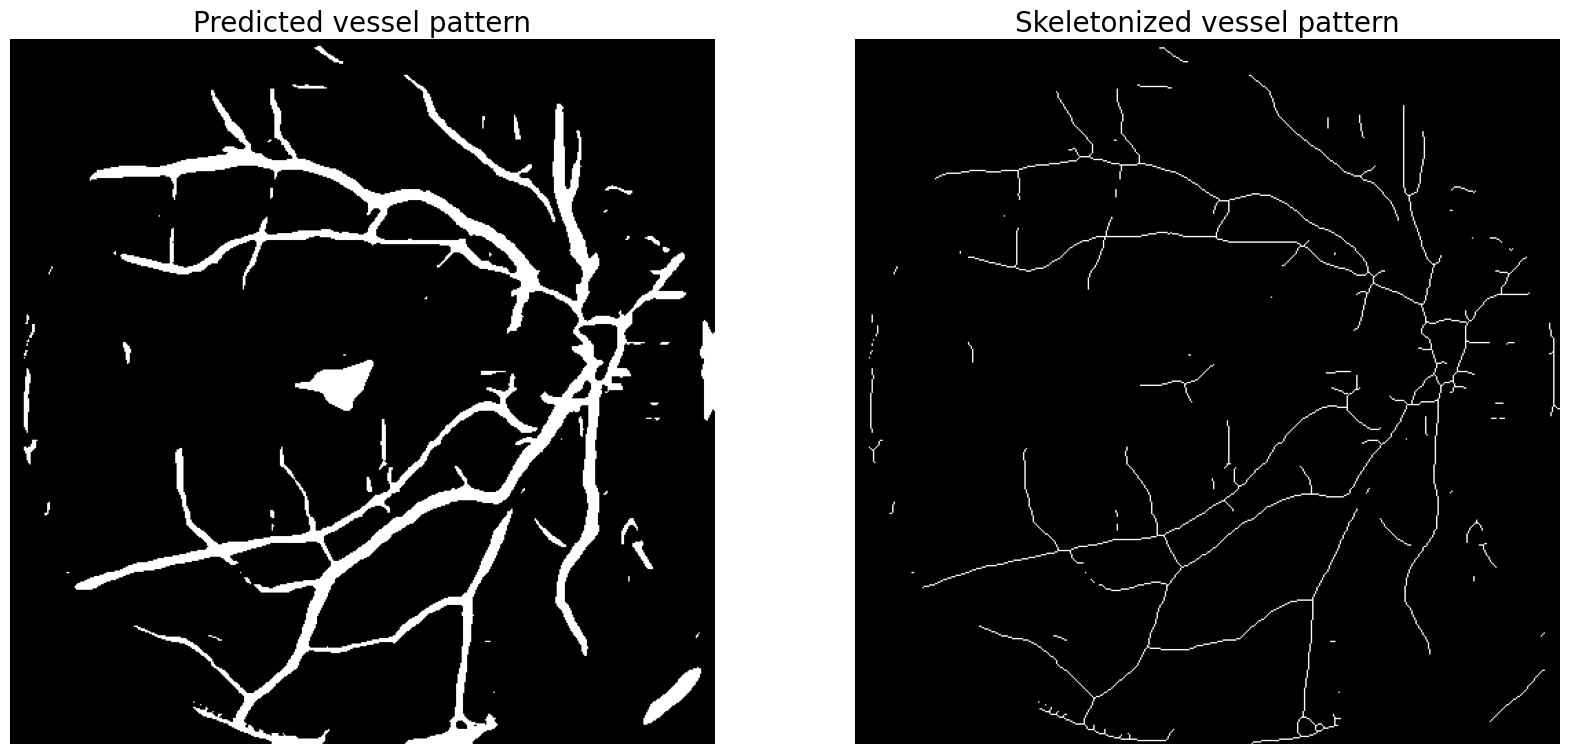

In [14]:
imgpath='test_preprocessed/DR/test_004.jpg'
image_preprocessed= skimage.io.imread(imgpath)
vessels = vessel_pattern(imgpath)
skeleton=vessel_pattern_skeletonized(imgpath)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,20))
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Predicted vessel pattern', fontsize=20)
ax2.set_title('Skeletonized vessel pattern', fontsize=20)


ax1.imshow(vessels, cmap='gray')
ax2.imshow(skeleton, cmap='gray')

plt.show()

## Us de la biblioteca skan per a trobar turtuositats al patró vascular

In [8]:
#encapsular-ho en una funció
def vessel_pattern_skeletonized(imgpath):
    image=vessel_pattern(imgpath) #la procesamos directamente con la función 
    # Comprobar si la imagen tiene tres canales (RGB)
    if image.ndim == 3 and image.shape[2] == 3:
        # Convertir a escala de grises si es necesario
        from skimage.color import rgb2gray
        gray_image = rgb2gray(image)
    else:
        # Si la imagen ya está en escala de grises o es binaria, continuar
        gray_image = image

    # Umbralizar la imagen si no está ya binarizada
    if gray_image.max() > 1:
        thresh = threshold_otsu(gray_image)
        binary_image = gray_image > thresh
    else:
        binary_image = gray_image

    # Esqueletonizar
    skeleton = skeletonize(binary_image)
    return(skeleton)
    

In [14]:
"""
# Crear el objeto Skeleton
skeleton_obj = Skeleton(skeleton)

# Sumarizar los datos del esqueleto
summary = summarize(skeleton_obj)
"""

In [15]:
summary

,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-dst-0,image-coord-dst-1,coord-src-0,coord-src-1,coord-dst-0,coord-dst-1,euclidean-distance
0,0,0,20,24.142136,0,1.0,0.0,6,221,16,241,6,221,16,241,22.360680
1,1,21,559,117.681241,1,1.0,0.0,26,286,99,367,26,286,99,367,109.041277
2,2,30,57,24.828427,0,1.0,0.0,33,205,35,229,33,205,35,229,24.083189
3,3,59,374,61.455844,1,1.0,0.0,36,190,90,206,36,190,90,206,56.320511
4,3,63,308,58.597980,1,1.0,0.0,38,146,85,170,38,146,85,170,52.773099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,3,3973,4006,12.242641,2,1.0,0.0,504,181,507,192,504,181,507,192,11.401754
190,3,3974,4020,4.414214,1,1.0,0.0,504,198,508,199,504,198,508,199,4.123106
191,3,3981,4006,2.414214,1,1.0,0.0,505,193,507,192,505,193,507,192,2.236068
192,3,3995,4077,37.071068,1,1.0,0.0,506,323,511,288,506,323,511,288,35.355339


In [16]:
"""
# Calcular la tortuosidad: longitud del segmento / distancia euclidiana
# Puedes definir un umbral para la tortuosidad a partir del cual considerarás que un vaso es tortuoso
tortuosity_threshold = 1.05  # Este valor es un ejemplo, ajústalo según tus necesidades
summary['tortuosity'] = summary['branch-distance'] / summary['euclidean-distance']
tortuous_segments = summary[summary['tortuosity'] > tortuosity_threshold]

# Imprimir los segmentos que son tortuosos
print(tortuous_segments)
"""


     skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0              0            0           20        24.142136            0   
1              1           21          559       117.681241            1   
3              3           59          374        61.455844            1   
4              3           63          308        58.597980            1   
6              4          124          217        17.242641            0   
..           ...          ...          ...              ...          ...   
187            3         3951         4020        36.899495            1   
188            3         3959         3995        14.242641            2   
189            3         3973         4006        12.242641            2   
190            3         3974         4020         4.414214            1   
191            3         3981         4006         2.414214            1   

     mean-pixel-value  stdev-pixel-value  image-coord-src-0  \
0                 1.0   

In [9]:
#función tortuosity para devolver la tortuosidad
"""
    Funció que retorna els segments més tortuosos a partir del patró vascular esqueletonitzat
    input: ruta a una imatge preprocessada utilitzada en el model, llindar de tortuositat
    output: segments tortuosos sobreposats a la imatge preprocessada aplican un mapa de color

"""

def tortuosity(imgpath, tortuosity_threshold):
    skeleton=vessel_pattern_skeletonized(imgpath)
    skeleton_obj=Skeleton(skeleton)

    summary = summarize(skeleton_obj)
    summary['tortuosity'] = summary['branch-distance'] / summary['euclidean-distance']
    summary_filtered= summary[summary['tortuosity'] > tortuosity_threshold]

    # Obtener el colormap
    #jet = cm.get_cmap('jet')
    jet = cm.get_cmap('jet', 256)

    # Normalizar los valores de tortuosidad para el rango del colormap
    min_tort = summary_filtered['tortuosity'].min()
    max_tort = summary_filtered['tortuosity'].max()
    normalized_tortuosity = (summary_filtered['tortuosity'] - min_tort) / (max_tort - min_tort)

    reconstructed_image = np.zeros((skeleton.shape[0], skeleton.shape[1], 3), dtype=np.uint8)

    for idx, row in summary_filtered.iterrows():
        path_coords = skeleton_obj.path_coordinates(idx)
    
        # Evitar errores de NaN y asegurar que el índice esté dentro del rango del colormap
        norm_tort_value = np.nan_to_num(normalized_tortuosity.loc[idx])
        color_idx = max(0, min(255, int(norm_tort_value * 255)))
        color = jet(color_idx)[:3]  # Obtener el color correspondiente al valor normalizado de tortuosidad
        color = (np.array(color) * 255).astype(np.uint8)  # Convertir a BGR para OpenCV
        color = color[::-1]  # Convertir de RGB a BGR

        # Draw the path if coordinates are available
        if len(path_coords) > 0:
            for i in range(len(path_coords) - 1):
                start_point = (int(path_coords[i][1]), int(path_coords[i][0]))
                end_point = (int(path_coords[i+1][1]), int(path_coords[i+0][0]))
                cv2.line(reconstructed_image, start_point, end_point, color=tuple(color.tolist()), thickness=4)
    return(reconstructed_image)


1/1 [==============================] - 0s 24ms/step


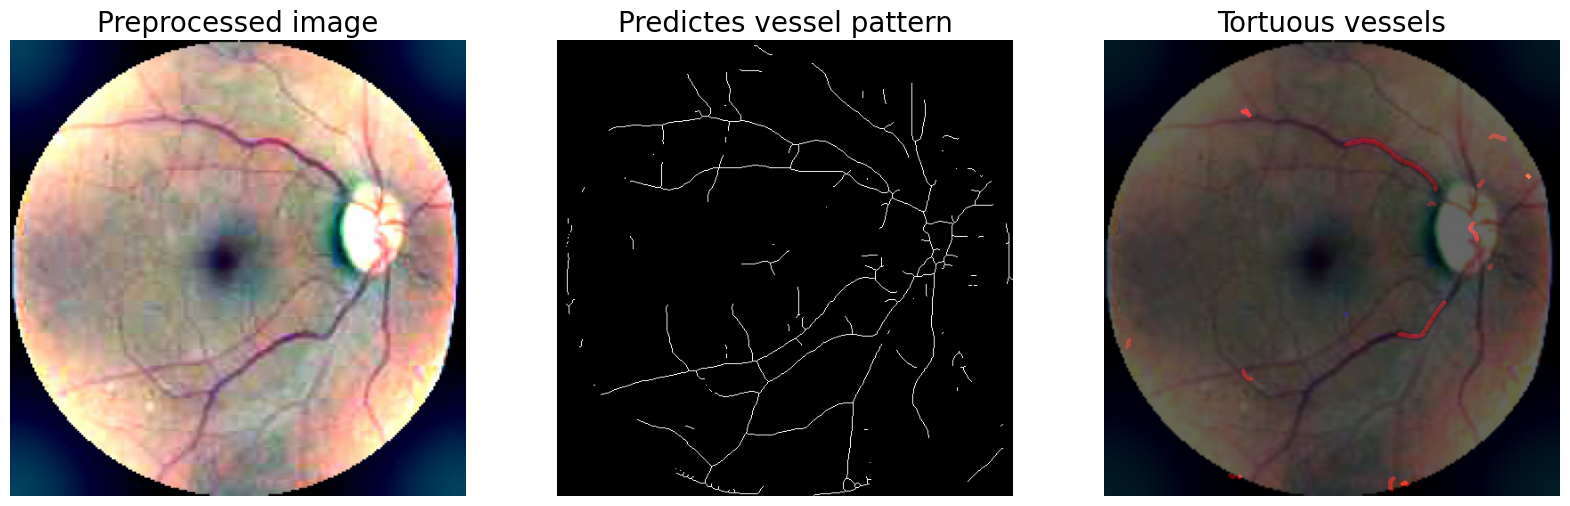

In [10]:
#prova en una imatge
imgpath='test_preprocessed/DR/test_004.jpg'
image_preprocessed= skimage.io.imread(imgpath) #imatge preprocessada
image_preprocessed_resized = resize(           #redimensionamos para superposición en ax3
    image_preprocessed, 
    (512, 512), 
    preserve_range=True, 
    anti_aliasing=True
    ).astype(image_preprocessed.dtype)

skeleton=vessel_pattern_skeletonized(imgpath)  #patró vascular squeletonitzat


tortuositat= tortuosity(imgpath, 1.15 )   #1.15 inicial


# Plot the results
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20,20))
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax1.set_title('Preprocessed image', fontsize=20)
ax2.set_title('Predictes vessel pattern', fontsize=20)
ax3.set_title('Tortuous vessels', fontsize=20)

ax1.imshow(image_preprocessed)
ax2.imshow(skeleton, cmap='gray')
ax3.imshow(image_preprocessed_resized)
ax3.imshow(tortuositat, alpha=0.6)
plt.show()

# Generar tots els patrons vasculars esqueletonitzats i tortuositats

In [58]:


preprocessed_source_folder = 'test_preprocessed/No_DR'
destination_folder='test_patro_vascular/No_DR'
images = os.listdir(preprocessed_source_folder)
for image in images:
    imgpath = os.path.join(preprocessed_source_folder, image)
    image_preprocessed= skimage.io.imread(imgpath) #imatge preprocessada
    image_preprocessed_resized = resize(           #redimensionamos para superposición en ax3
    image_preprocessed, 
    (512, 512), 
    preserve_range=True, 
    anti_aliasing=True
    ).astype(image_preprocessed.dtype)
    skeleton=vessel_pattern_skeletonized(imgpath)  #patró vascular squeletonitzat
    tortuositat= tortuosity(imgpath, 1.15 )

   # Plot the results
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20,20))
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')
    ax1.set_title('Preprocessed image', fontsize=20)
    ax2.set_title('Predictes vessel pattern', fontsize=20)
    ax3.set_title('Tortuous vessels', fontsize=20)

    ax1.imshow(image_preprocessed)
    ax2.imshow(skeleton, cmap='gray')
    ax3.imshow(image_preprocessed_resized)
    ax3.imshow(tortuositat, cmap='gray', alpha=0.6)
    # Guardar la figura completa en un archivo
    save_path = os.path.join(destination_folder, image)
    fig.savefig(save_path, bbox_inches='tight')
    print(f"Figure saved as {save_path}")
    plt.close(fig)  # Cierra la figura para liberar memoria

1/1 [==============================] - 0s 25ms/step
Figure saved as test_patro_vascular/No_DR\test_114.jpg
1/1 [==============================] - 0s 25ms/step
Figure saved as test_patro_vascular/No_DR\test_115.jpg
1/1 [==============================] - 0s 16ms/step
Figure saved as test_patro_vascular/No_DR\test_116.jpg
1/1 [==============================] - 0s 28ms/step
Figure saved as test_patro_vascular/No_DR\test_117.jpg
1/1 [==============================] - 0s 31ms/step
Figure saved as test_patro_vascular/No_DR\test_118.jpg
1/1 [==============================] - 0s 31ms/step
Figure saved as test_patro_vascular/No_DR\test_119.jpg
1/1 [==============================] - 0s 47ms/step
Figure saved as test_patro_vascular/No_DR\test_120.jpg
1/1 [==============================] - 0s 23ms/step
Figure saved as test_patro_vascular/No_DR\test_121.jpg
1/1 [==============================] - 0s 16ms/step
Figure saved as test_patro_vascular/No_DR\test_122.jpg
1/1 [==============================] 

1/1 [==============================] - 0s 16ms/step
Figure saved as test_patro_vascular/No_DR\test_217.jpg
1/1 [==============================] - 0s 16ms/step
Figure saved as test_patro_vascular/No_DR\test_218.jpg
1/1 [==============================] - 0s 16ms/step
Figure saved as test_patro_vascular/No_DR\test_219.jpg
1/1 [==============================] - 0s 20ms/step
Figure saved as test_patro_vascular/No_DR\test_220.jpg
1/1 [==============================] - 0s 16ms/step
Figure saved as test_patro_vascular/No_DR\test_221.jpg
1/1 [==============================] - 0s 31ms/step
Figure saved as test_patro_vascular/No_DR\test_222.jpg
1/1 [==============================] - 0s 31ms/step
Figure saved as test_patro_vascular/No_DR\test_223.jpg
1/1 [==============================] - 0s 31ms/step
Figure saved as test_patro_vascular/No_DR\test_224.jpg
1/1 [==============================] - 0s 16ms/step
Figure saved as test_patro_vascular/No_DR\test_225.jpg
1/1 [==============================] 

# Generar tots els patrons vasculars esqueletonitzats 

In [33]:
preprocessed_source_folder = 'test_preprocessed/No_DR'
destination_folder='test_patterns/No_DR'
images = os.listdir(preprocessed_source_folder)
count=0
for image in images:
    imgpath = os.path.join(preprocessed_source_folder, image)

    tortuositat= tortuosity(imgpath, 1.15 )

    # Plot the results
    fig, ax = plt.subplots(figsize=(3.7,3.7))
    ax.axis('off')

    ax.imshow(skeleton, cmap='gray')

    #plt.show()
    
    # Guardar la figura completa en un archivo
    save_path = os.path.join(destination_folder, image)
    fig.savefig(save_path, bbox_inches='tight')
    print(f"Figure saved as {save_path}")
    plt.close(fig)  # Cierra la figura para liberar memoria

1/1 [==============================] - 0s 23ms/step
Figure saved as test_patterns/No_DR\test_114.jpg
1/1 [==============================] - 0s 25ms/step
Figure saved as test_patterns/No_DR\test_115.jpg
1/1 [==============================] - 0s 16ms/step
Figure saved as test_patterns/No_DR\test_116.jpg
1/1 [==============================] - 0s 25ms/step
Figure saved as test_patterns/No_DR\test_117.jpg
1/1 [==============================] - 0s 22ms/step
Figure saved as test_patterns/No_DR\test_118.jpg
1/1 [==============================] - 0s 25ms/step
Figure saved as test_patterns/No_DR\test_119.jpg
1/1 [==============================] - 0s 23ms/step
Figure saved as test_patterns/No_DR\test_120.jpg
1/1 [==============================] - 0s 37ms/step
Figure saved as test_patterns/No_DR\test_121.jpg
1/1 [==============================] - 0s 17ms/step
Figure saved as test_patterns/No_DR\test_122.jpg
1/1 [==============================] - 0s 35ms/step
Figure saved as test_patterns/No_DR\tes

# Generar totes les tortuositats 

In [43]:
preprocessed_source_folder = 'test_preprocessed/No_DR'
destination_folder='test_tortuosity/No_DR'
images = os.listdir(preprocessed_source_folder)
count=0
for image in images:
    imgpath = os.path.join(preprocessed_source_folder, image)
    
    image_preprocessed= skimage.io.imread(imgpath) #imatge preprocessada
    image_preprocessed_resized = resize(           #redimensionamos para superposición en ax3
    image_preprocessed, 
    (512, 512), 
    preserve_range=True, 
    anti_aliasing=True
    ).astype(image_preprocessed.dtype)
    

    tortuositat= tortuosity(imgpath, 1.15 ) 

   # Plot the results
    fig, ax = plt.subplots(figsize=(3.7,3.7))
    ax.axis('off')
    ax.imshow(image_preprocessed_resized)
    ax.imshow(tortuositat, alpha=0.6)

    #plt.show()
    #count+=1
    #if count==3: break
    
    # Guardar la figura completa en un archivo
    save_path = os.path.join(destination_folder, image)
    fig.savefig(save_path, bbox_inches='tight')
    print(f"Figure saved as {save_path}")
    plt.close(fig)  # Cierra la figura para liberar memoria


1/1 [==============================] - 0s 31ms/step
Figure saved as test_tortuosity/No_DR\test_114.jpg
1/1 [==============================] - 0s 31ms/step
Figure saved as test_tortuosity/No_DR\test_115.jpg
1/1 [==============================] - 0s 23ms/step
Figure saved as test_tortuosity/No_DR\test_116.jpg
1/1 [==============================] - 0s 23ms/step
Figure saved as test_tortuosity/No_DR\test_117.jpg
1/1 [==============================] - 0s 19ms/step
Figure saved as test_tortuosity/No_DR\test_118.jpg
1/1 [==============================] - 0s 8ms/step
Figure saved as test_tortuosity/No_DR\test_119.jpg
1/1 [==============================] - 0s 9ms/step
Figure saved as test_tortuosity/No_DR\test_120.jpg
1/1 [==============================] - 0s 25ms/step
Figure saved as test_tortuosity/No_DR\test_121.jpg
1/1 [==============================] - 0s 23ms/step
Figure saved as test_tortuosity/No_DR\test_122.jpg
1/1 [==============================] - 0s 23ms/step
Figure saved as test_to

1/1 [==============================] - 0s 16ms/step
Figure saved as test_tortuosity/No_DR\test_194.jpg
1/1 [==============================] - 0s 31ms/step
Figure saved as test_tortuosity/No_DR\test_195.jpg
1/1 [==============================] - 0s 16ms/step
Figure saved as test_tortuosity/No_DR\test_196.jpg
1/1 [==============================] - 0s 31ms/step
Figure saved as test_tortuosity/No_DR\test_197.jpg
1/1 [==============================] - 0s 16ms/step
Figure saved as test_tortuosity/No_DR\test_198.jpg
1/1 [==============================] - 0s 31ms/step
Figure saved as test_tortuosity/No_DR\test_199.jpg
1/1 [==============================] - 0s 31ms/step
Figure saved as test_tortuosity/No_DR\test_200.jpg
1/1 [==============================] - 0s 16ms/step
Figure saved as test_tortuosity/No_DR\test_201.jpg
1/1 [==============================] - 0s 16ms/step
Figure saved as test_tortuosity/No_DR\test_202.jpg
1/1 [==============================] - 0s 28ms/step
Figure saved as test_

### Funció tortuosity binaritzada 

In [8]:
def tortuosity_binarized(imgpath, tortuosity_threshold):
    skeleton = vessel_pattern_skeletonized(imgpath)
    skeleton_obj = Skeleton(skeleton)

    summary = summarize(skeleton_obj)
    summary['tortuosity'] = summary['branch-distance'] / summary['euclidean-distance']
    summary_filtered = summary[summary['tortuosity'] > tortuosity_threshold]

    # Preparar la imagen binarizada
    reconstructed_image = np.zeros((skeleton.shape[0], skeleton.shape[1]), dtype=np.uint8)  # Imagen en blanco y negro

    for idx, row in summary_filtered.iterrows():
        path_coords = skeleton_obj.path_coordinates(idx)

        # Dibujar el camino si hay coordenadas disponibles
        if len(path_coords) > 0:
            for i in range(len(path_coords) - 1):
                start_point = (int(path_coords[i][1]), int(path_coords[i][0]))
                end_point = (int(path_coords[i+1][1]), int(path_coords[i+0][0]))
                # Usar color blanco (255) para las líneas que superan el umbral de tortuosidad
                cv2.line(reconstructed_image, start_point, end_point, color=255, thickness=4)
    return reconstructed_image


## Generar totes les tortuositats binaritzades 

In [14]:
#Excutar per DR i No_dR
preprocessed_source_folder = 'valid_preprocessed/DR'
destination_folder='valid_tortuosity_binarized/DR'
images = os.listdir(preprocessed_source_folder)
count=0
for image in images:
    imgpath = os.path.join(preprocessed_source_folder, image)   
    tortuositat= tortuosity_binarized(imgpath, 1.10 )  #ull inicial 1.15
    resized_tortuositat = cv2.resize(tortuositat, (224,224), interpolation=cv2.INTER_NEAREST)
    save_path = os.path.join(destination_folder, image)
    cv2.imwrite(save_path, resized_tortuositat)
    print(f"Figure saved as {save_path}")

     

1/1 [==============================] - 0s 23ms/step
Figure saved as valid_tortuosity_binarized/DR\valid_001.jpg
1/1 [==============================] - 0s 16ms/step
Figure saved as valid_tortuosity_binarized/DR\valid_002.jpg
1/1 [==============================] - 0s 23ms/step
Figure saved as valid_tortuosity_binarized/DR\valid_003.jpg
1/1 [==============================] - 0s 22ms/step
Figure saved as valid_tortuosity_binarized/DR\valid_004.jpg
1/1 [==============================] - 0s 23ms/step
Figure saved as valid_tortuosity_binarized/DR\valid_005.jpg
1/1 [==============================] - 0s 9ms/step
Figure saved as valid_tortuosity_binarized/DR\valid_006.jpg
1/1 [==============================] - 0s 21ms/step
Figure saved as valid_tortuosity_binarized/DR\valid_007.jpg
1/1 [==============================] - 0s 22ms/step
Figure saved as valid_tortuosity_binarized/DR\valid_008.jpg
1/1 [==============================] - 0s 17ms/step
Figure saved as valid_tortuosity_binarized/DR\valid_0

1/1 [==============================] - 0s 31ms/step
Figure saved as valid_tortuosity_binarized/DR\valid_147.jpg
1/1 [==============================] - 0s 31ms/step
Figure saved as valid_tortuosity_binarized/DR\valid_148.jpg
1/1 [==============================] - 0s 31ms/step
Figure saved as valid_tortuosity_binarized/DR\valid_149.jpg
1/1 [==============================] - 0s 31ms/step
Figure saved as valid_tortuosity_binarized/DR\valid_150.jpg
1/1 [==============================] - 0s 16ms/step
Figure saved as valid_tortuosity_binarized/DR\valid_151.jpg
1/1 [==============================] - 0s 16ms/step
Figure saved as valid_tortuosity_binarized/DR\valid_152.jpg
1/1 [==============================] - 0s 16ms/step
Figure saved as valid_tortuosity_binarized/DR\valid_153.jpg
1/1 [==============================] - 0s 16ms/step
Figure saved as valid_tortuosity_binarized/DR\valid_154.jpg
1/1 [==============================] - 0s 16ms/step
Figure saved as valid_tortuosity_binarized/DR\valid_

1/1 [==============================] - 0s 23ms/step


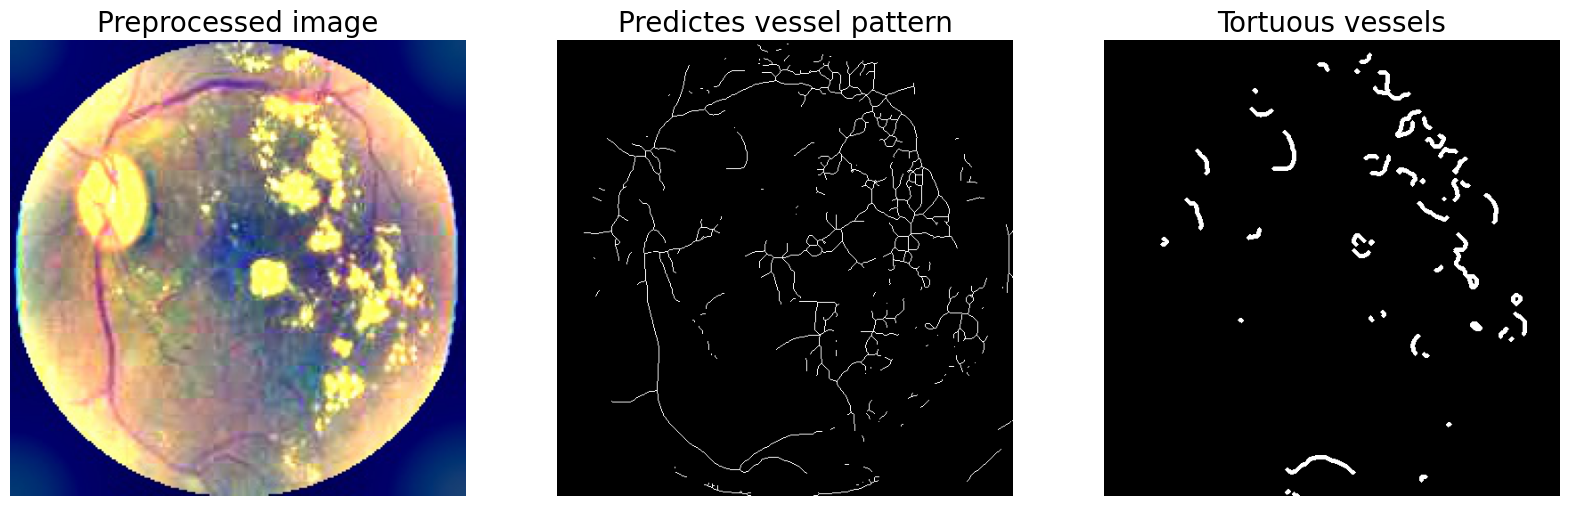

In [11]:
#prova en una imatge
imgpath='test_002.jpg'
image_preprocessed= skimage.io.imread(imgpath) #imatge preprocessada
image_preprocessed_resized = resize(           #redimensionamos para superposición en ax3
    image_preprocessed, 
    (512, 512), 
    preserve_range=True, 
    anti_aliasing=True
    ).astype(image_preprocessed.dtype)

skeleton=vessel_pattern_skeletonized(imgpath)  #patró vascular squeletonitzat


tortuositat= tortuosity(imgpath, 1.15 )


# Plot the results
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20,20))
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax1.set_title('Preprocessed image', fontsize=20)
ax2.set_title('Predictes vessel pattern', fontsize=20)
ax3.set_title('Tortuous vessels', fontsize=20)

ax1.imshow(image_preprocessed)
ax2.imshow(skeleton, cmap='gray')
ax3.imshow(tortuositat, cmap='gray')
plt.show()